## k-Nearest-Neighbors V1.0
- all datetime feature
- random cross validation
- hyperparameter tuning

**Hyperparameter:**
- neighbors
- weights
- leaf-size

##### Vorteile
* einfach zu verstehen und zu implementieren
* quasi keine Trainingszeit, eignet sich somit gut als Einstiegsalgorithmus für neue Daten
* Funktioniert genauso für Probleme mit mehr als 2 Klassen
* Macht keine Annhame über die statistischen Eigenschaften der Daten und performt deshalb teilweise besser in Situation mit "sehr ungewöhnlichen" Daten

##### Nachteile
* Rechenintensive Testphase, deshalb nicht gut für produktiven Einsatz geeignet
* Es kann zu Problemen führen, falls eine Klasse deutlich stärker vertreten ist (diese Klasse dominiert dann das *majority voting*)
* Daten mit vielen Input-Variablen sind nicht gut für $k$-NN geeignet, da, grob-gesagt, in einem Vektorraum von hoher Dimension der Abstand zwischen dem nächsten und dem entferntesten Nachbarn nicht allzu groß ist.

#### **_PREPARATION_**

In [1]:
# GET ALL THE JSONS INTO ONE DATAFRAME
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import glob

In [2]:
# Set the search path for files (assuming the directory is relative to the current script)
file_path_mc124 = os.path.join("..", "fine_dust_complete", ".csv")
df = pd.read_csv('./../fine_dust_complete.csv')

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 539422 entries, 0 to 542554
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     539422 non-null  object 
 1   station      539422 non-null  object 
 2   core         539422 non-null  object 
 3   value        539422 non-null  float64
 4   hour         539422 non-null  int64  
 5   day          539422 non-null  int64  
 6   month        539422 non-null  int64  
 7   year         539422 non-null  int64  
 8   day_of_week  539422 non-null  int64  
 9   is_weekend   539422 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 45.3+ MB


In [3]:
df_pm10 = df[(df['core'] == 'pm10')]
df_pm10.head()

,datetime,station,core,value,hour,day,month,year,day_of_week,is_weekend
188328,2016-03-31 23:00:00,mc124,pm10,16.0,23,31,3,2016,3,0
188332,2016-03-31 22:00:00,mc124,pm10,22.0,22,31,3,2016,3,0
188336,2016-03-31 21:00:00,mc124,pm10,22.0,21,31,3,2016,3,0
188340,2016-03-31 20:00:00,mc124,pm10,24.0,20,31,3,2016,3,0
188344,2016-03-31 19:00:00,mc124,pm10,21.0,19,31,3,2016,3,0


#### **_ACTUAL MODEL TRAINING_**


#### Part 1: create random forest ensemble on everything

In [4]:
# create features and to be predicted value
y = df_pm10['value']
X = df_pm10[['hour', 'day', 'month', 'year', 'day_of_week', 'is_weekend']]

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

In [6]:
knn = KNeighborsRegressor(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

1.0

In [7]:
knn.score(X_test, y_test)

0.4915652696313443

In [8]:
knn =  KNeighborsRegressor(n_neighbors=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

0.19581650439342857

In [9]:
knn.score(X_test, y_test)
# R2 score: vergleichen Modellvorhersagen mit der Abweichung vom Mittelwert, im Vergleich mit absoluten banalsten Mittelwert vorhersage
# d.h. Vergleicht die Vorhersage des Modells vs einfach den absoluten Mittelwert für die X vorherzusagen
# je höher desto besser

0.12917593705840746

In [10]:
#rf.estimator.tree_.max_depth

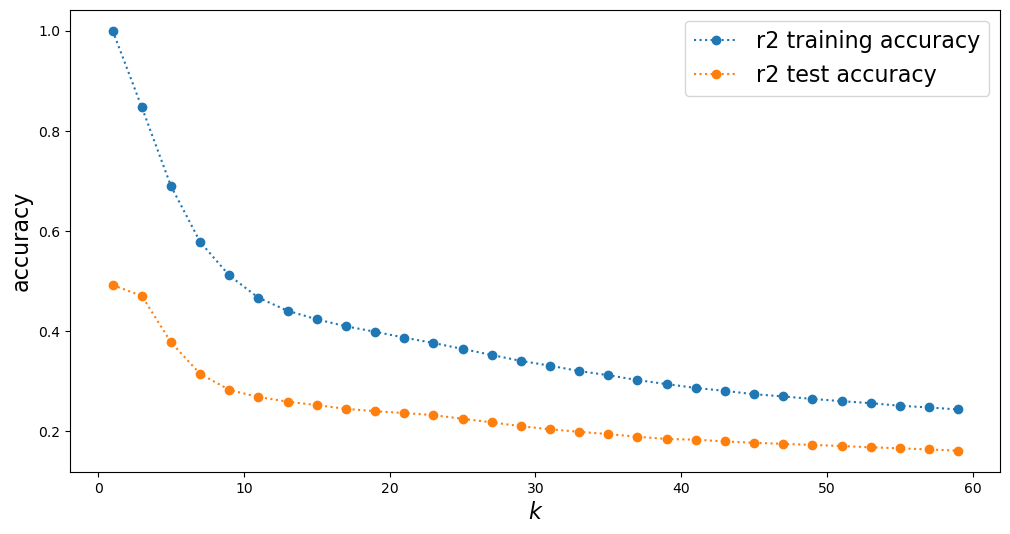

In [11]:
# k result visualisation
fig, ax = plt.subplots(1, 1, figsize=(12,6))
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 60, 2)
for n_neighbors in neighbors_settings:
# build the model
    clf = KNeighborsRegressor(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)# record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train)) # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="r2 training accuracy", 
         linestyle=':', marker='o')
plt.plot(neighbors_settings, test_accuracy, label="r2 test accuracy", 
         linestyle=':', marker='o')
plt.ylabel("accuracy", fontsize=16)
plt.xlabel("$k$", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('train_test_accuracy_kNN.png', bbox_inches='tight', facecolor="w", dpi=300);

#### CROSS-VALIDATION & HYPERPARAMETER TUNING

In [12]:
# cross validate
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, root_mean_squared_error

# Create a kNN regressor
knn = KNeighborsRegressor(n_neighbors=10)

# Define your scoring functions
scorers = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
    'root_mean_squared_error': make_scorer(root_mean_squared_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}
# Perform cross-validation
# scores = cross_validate(decision_tree, X, y, cv=2, scoring=scorers, return_train_score=True)
scores = cross_validate(knn, X, y, cv=5, scoring=scorers, return_train_score=True)

# Print the results
print("Cross-validation scores:")
for scorer, score in scores.items():
    print(f"{scorer}: {-1*np.mean(score):.2f} (+/- {np.std(score):.2f})")

Cross-validation scores:
fit_time: -0.12 (+/- 0.02)
score_time: -0.34 (+/- 0.10)
test_mean_absolute_error: 9.70 (+/- 0.54)
train_mean_absolute_error: 5.91 (+/- 0.15)
test_median_absolute_error: 7.23 (+/- 0.47)
train_median_absolute_error: 4.28 (+/- 0.12)
test_root_mean_squared_error: 14.23 (+/- 1.10)
train_root_mean_squared_error: 9.32 (+/- 0.20)
test_mean_squared_error: 203.62 (+/- 31.28)
train_mean_squared_error: 86.84 (+/- 3.79)


- overfitting: perfoms decently on train data but nearly twice as worse on test data

In [13]:
# average pm10 value for comparison to the error rates
average_pm10 = df_pm10['value'].mean()
print(f"Average PM10 value: {average_pm10:.2f}")

Average PM10 value: 22.70


In [14]:
median_pm10= df_pm10['value'].median()
print(f"Median PM10 value: {median_pm10:.2f}")

Median PM10 value: 20.00


In [15]:
#----------------------------------------------------
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.datasets import make_regression
import numpy as np

# TODO: change these
# Valid parameters are: ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].
param_grid = {
    'n_neighbors': range(5, 20, 5),
    'weights': ["uniform", "distance"],
   # 'algorithm': ["ball_tree", "kd_tree", "brute", "auto"],
    'leaf_size': [5, 10, 15, 20, 25, 30, 40, 50]
}

# Define your scoring functions
scorers = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
    'root_mean_squared_error': make_scorer(root_mean_squared_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Initialize the RandomForestRegressor
regressor = KNeighborsRegressor()

# Initialize GridSearchCV with the regressor and the parameter grid
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_median_absolute_error')

# Fit GridSearchCV to the data
grid_search.fit(X, y)

# Get the best estimator from the grid search
best_regressor = grid_search.best_estimator_

# Perform cross-validation with the best estimator and the scoring functions
scores = cross_validate(best_regressor, X, y, cv=5, scoring=scorers, return_train_score=True)

print("Cross-validation scores:")
for scorer, score in scores.items():
    print(f"{scorer}: {-1*np.mean(score):.2f} (+/- {np.std(score):.2f})")

Cross-validation scores:
fit_time: -0.08 (+/- 0.01)
score_time: -0.28 (+/- 0.05)
test_mean_absolute_error: 9.35 (+/- 0.52)
train_mean_absolute_error: 6.44 (+/- 0.15)
test_median_absolute_error: 7.04 (+/- 0.37)
train_median_absolute_error: 4.72 (+/- 0.14)
test_root_mean_squared_error: 13.77 (+/- 1.13)
train_root_mean_squared_error: 10.06 (+/- 0.23)
test_mean_squared_error: 190.77 (+/- 31.30)
train_mean_squared_error: 101.16 (+/- 4.52)


In [16]:
best_regressor

KNeighborsRegressor(leaf_size=15, n_neighbors=15)

In [17]:
best_regressor.algorithm

'auto'

In [18]:
best_regressor.weights

'uniform'